# Carys BM789
## Xiaonan Wang
## 15Mar2020

In [1]:
#%matplotlib nbagg
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import os
import smqpp
import re
import anndata

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(name='gene_cmap', colors=['lightgrey', 'thistle', 'red', 'darkred']) 

sc.settings.set_figure_params(dpi=80, color_map='viridis', vector_friendly=False,  dpi_save=300)

/home/xw251/miniconda3/envs/scanpy_py368/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


scanpy==1.5.0 anndata==0.7.1 numpy==1.18.2 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1 leidenalg==0.7.0


In [2]:
# read in metadata
# Since the metadata has been tidied up previously in R (Carys_MPB1234.R)
# Here I just the output from R
meta = pd.read_csv('/home/xw251/rds/rds-bg200-hphi-gottgens/users/xw251/Lab_Members/Carys/BM789/BM_data/MetaData/meta_BM789_combined.txt', delimiter='\t')
meta.index = meta['ID']
print(meta.shape)
display(meta.head(1))

(861, 31)


Gottgens_ID_RBGxxx CRI_identifier    CRI_run  \
ID                                                                 
SLX.11474.i716_i513           RBG10578      SLX_11474  SCACCF#21   

                      Plate_number Position_in_96_well_plate_sorted  \
ID                                                                    
SLX.11474.i716_i513  S07_d3_Plate1                               A1   

                    Position_in_96_well_plate_RNA_seq FACs_index_data  \
ID                                                                      
SLX.11474.i716_i513                                A1             Yes   

                     BGI_code        Sample_name  \
ID                                                 
SLX.11474.i716_i513       NaN  d3 CD34+ NT (S07)   

                                                               Details  ...  \
ID                                                                      ...   
SLX.11474.i716_i513  d3_bone_marrow_derived_CD34+_Non_Transduced (S07)  ...   

                    Number_of_lanes  \
ID                                    
SLX.11474.i716_i513               1   

                    Number_of_additional_lanes_ordered_i_e_repeats  Paid_Y_N  \
ID                                                                             
SLX.11474.i716_i513                                            NaN       NaN   

                    Invoice_number Price Cell_Type   Day Condition  Batch  \
ID                                                                          
SLX.11474.i716_i513            NaN   NaN     CD34+  Day3      GFP-    S07   

                                      ID  
ID                                        
SLX.11474.i716_i513  SLX.11474.i716_i513  

[1 rows x 31 columns]

In [3]:
meta['con_comb'] = meta['Day'].astype(str)+'_'+meta['Cell_Type'].astype(str)+'_'+meta['Condition'].astype(str)
meta['con_comb'].value_counts().sort_index()

Day0_CD34+_NT       93
Day0_LT-HSC_NT      96
Day0_ST-HSC_NT      96
Day3_CD34+_GFP-     90
Day3_CD34+_T        96
Day3_LT-HSC_GFP-    96
Day3_LT-HSC_T       96
Day3_ST-HSC_GFP-    96
Day3_ST-HSC_T       96
EB_EB_EB             6
Name: con_comb, dtype: int64

In [3]:
# Here will just use the feature file from MPB as they are the same
#gtpfile = '/home/xw251/rds/rds-bg200-hphi-gottgens/users/xw251/programs/Cellranger_RefGenome/Homo_sapians_GRCh38_ERCC92_GFP.gtf'
ftable_loc = '/home/xw251/rds/rds-bg200-hphi-gottgens/users/xw251/Lab_Members/Carys/MPB1234/MPB_data/features.tsv'
#smqpp.generate_feature_table(gtpfile, ftable_loc)

In [4]:
Indir = '/home/xw251/rds/rds-bg200-hphi-gottgens/users/xw251/Lab_Members/Carys/BM789/BM_data/Count_files/'
folder_list = np.array(os.listdir(Indir))
folder_list = np.sort(folder_list)
print(folder_list)

['Sort7_count.txt' 'Sort8_count.txt' 'Sort9_count.txt']


In [10]:
# define QC thresholds
cutoff1 = {'nMapped (log10)': 0,
           'nNuclear (log10)': np.log10(100000),
           'fGenes:nTotal': 0.15,
           'nHCGenes': 0,
           'mito:nGenes': 0.25,
           'nERCC:nMapped': 0.1
          }
cutoff2 = {'nMapped (log10)': 0,
           'nNuclear (log10)': np.log10(100000),
           'fGenes:nTotal': 0.15,
           'nHCGenes': 0,
           'mito:nGenes': 0.25,
           'nERCC:nMapped': 0.1
          }
cutoff3 = {'nMapped (log10)': 0,
           'nNuclear (log10)': np.log10(100000),
           'fGenes:nTotal': 0.15,
           'nHCGenes': 0,
           'mito:nGenes': 0.25,
           'nERCC:nMapped': 0.25
          }
cutoff = [cutoff1, cutoff2, cutoff3]

Sort7_count.txt
Count table shape: (285, 65989)
Feature table shape:(65989, 2)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


mito_genes: ['MT-ND6', 'MT-CO2', 'MT-CYB', 'MT-ND2', 'MT-ND5', 'MT-CO1', 'MT-ND3', 'MT-ND4', 'MT-ND1', 'MT-ATP6', 'MT-CO3', 'MT-TL1', 'MT-TF', 'MT-TV', 'MT-RNR2', 'MT-TI', 'MT-TQ', 'MT-TM', 'MT-TW', 'MT-TA', 'MT-TN', 'MT-TC', 'MT-TY', 'MT-TS1', 'MT-TD', 'MT-TK', 'MT-TG', 'MT-TR', 'MT-TH', 'MT-TS2', 'MT-TL2', 'MT-TE', 'MT-TT', 'MT-TP', 'MT-RNR1', 'MT-ND4L', 'MT-ATP8']
Number of passed cells: 248
Number of failed cells: 37
Sort8_count.txt
Count table shape: (285, 65989)
Feature table shape:(65989, 2)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


mito_genes: ['MT-ND6', 'MT-CO2', 'MT-CYB', 'MT-ND2', 'MT-ND5', 'MT-CO1', 'MT-ND3', 'MT-ND4', 'MT-ND1', 'MT-ATP6', 'MT-CO3', 'MT-TL1', 'MT-TF', 'MT-TV', 'MT-RNR2', 'MT-TI', 'MT-TQ', 'MT-TM', 'MT-TW', 'MT-TA', 'MT-TN', 'MT-TC', 'MT-TY', 'MT-TS1', 'MT-TD', 'MT-TK', 'MT-TG', 'MT-TR', 'MT-TH', 'MT-TS2', 'MT-TL2', 'MT-TE', 'MT-TT', 'MT-TP', 'MT-RNR1', 'MT-ND4L', 'MT-ATP8']
Number of passed cells: 216
Number of failed cells: 69
Sort9_count.txt
Count table shape: (285, 65989)
Feature table shape:(65989, 2)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


mito_genes: ['MT-ND6', 'MT-CO2', 'MT-CYB', 'MT-ND2', 'MT-ND5', 'MT-CO1', 'MT-ND3', 'MT-ND4', 'MT-ND1', 'MT-ATP6', 'MT-CO3', 'MT-TL1', 'MT-TF', 'MT-TV', 'MT-RNR2', 'MT-TI', 'MT-TQ', 'MT-TM', 'MT-TW', 'MT-TA', 'MT-TN', 'MT-TC', 'MT-TY', 'MT-TS1', 'MT-TD', 'MT-TK', 'MT-TG', 'MT-TR', 'MT-TH', 'MT-TS2', 'MT-TL2', 'MT-TE', 'MT-TT', 'MT-TP', 'MT-RNR1', 'MT-ND4L', 'MT-ATP8']
Number of passed cells: 170
Number of failed cells: 115


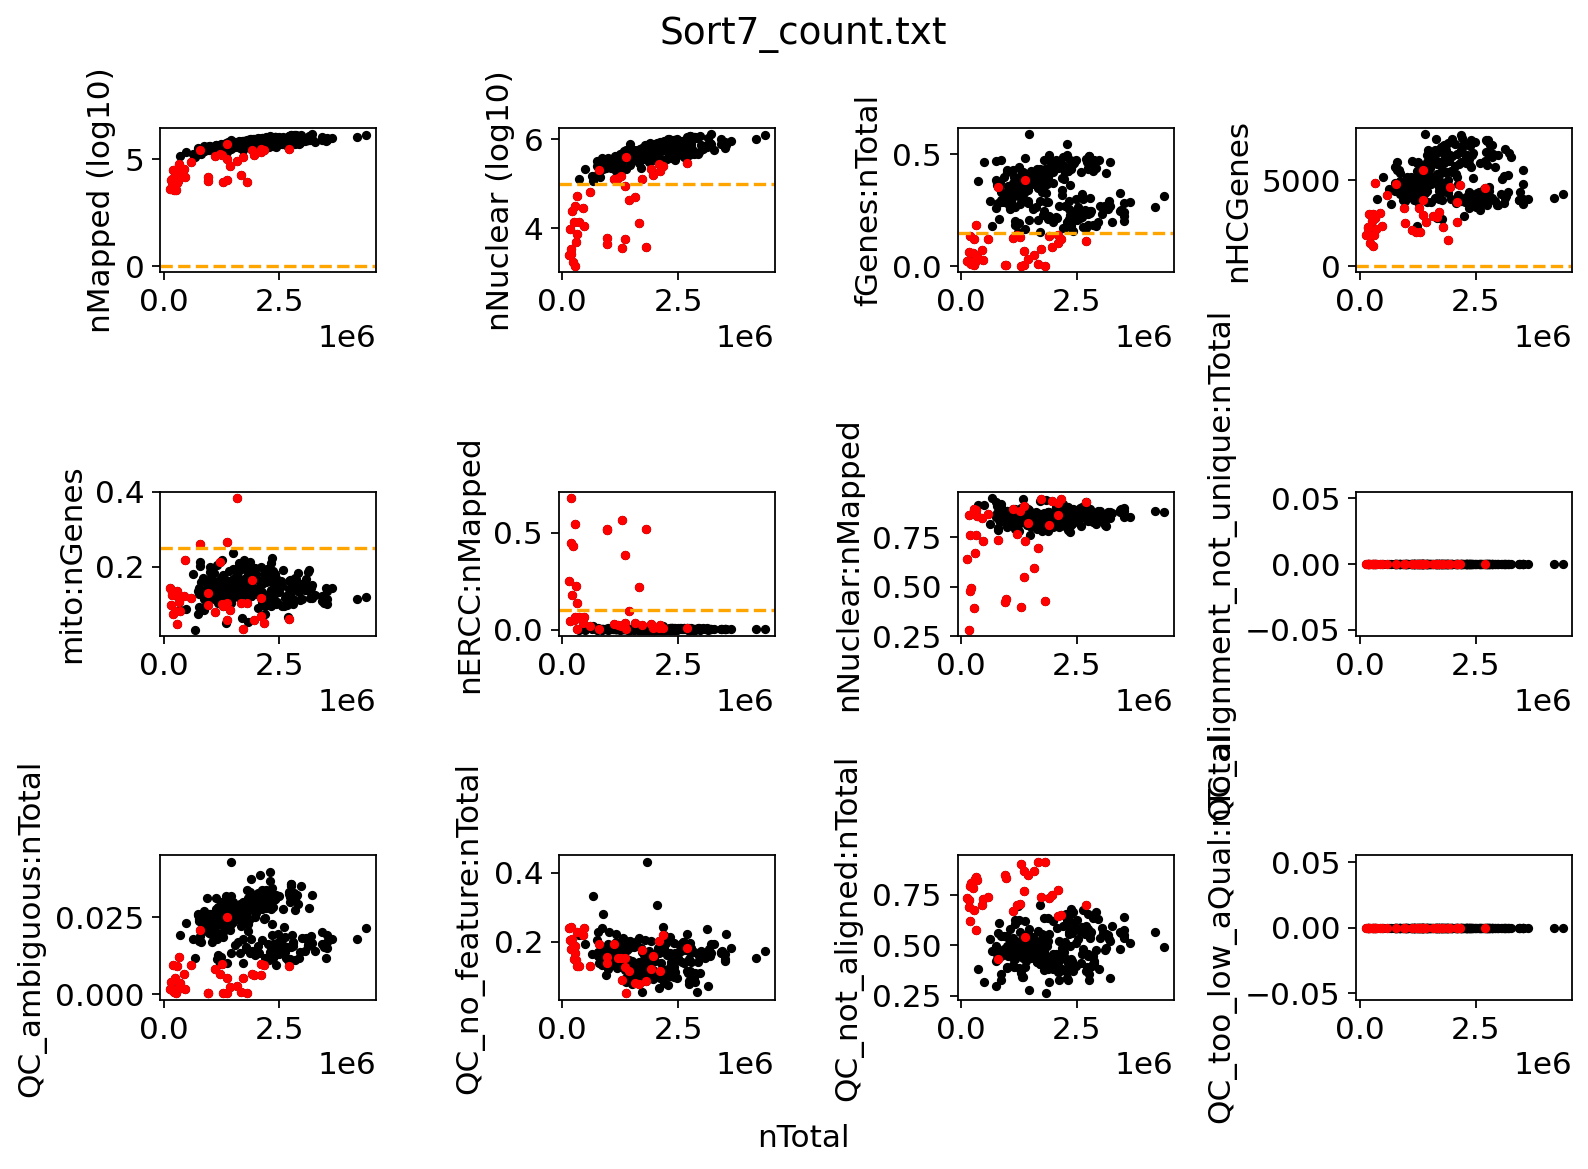

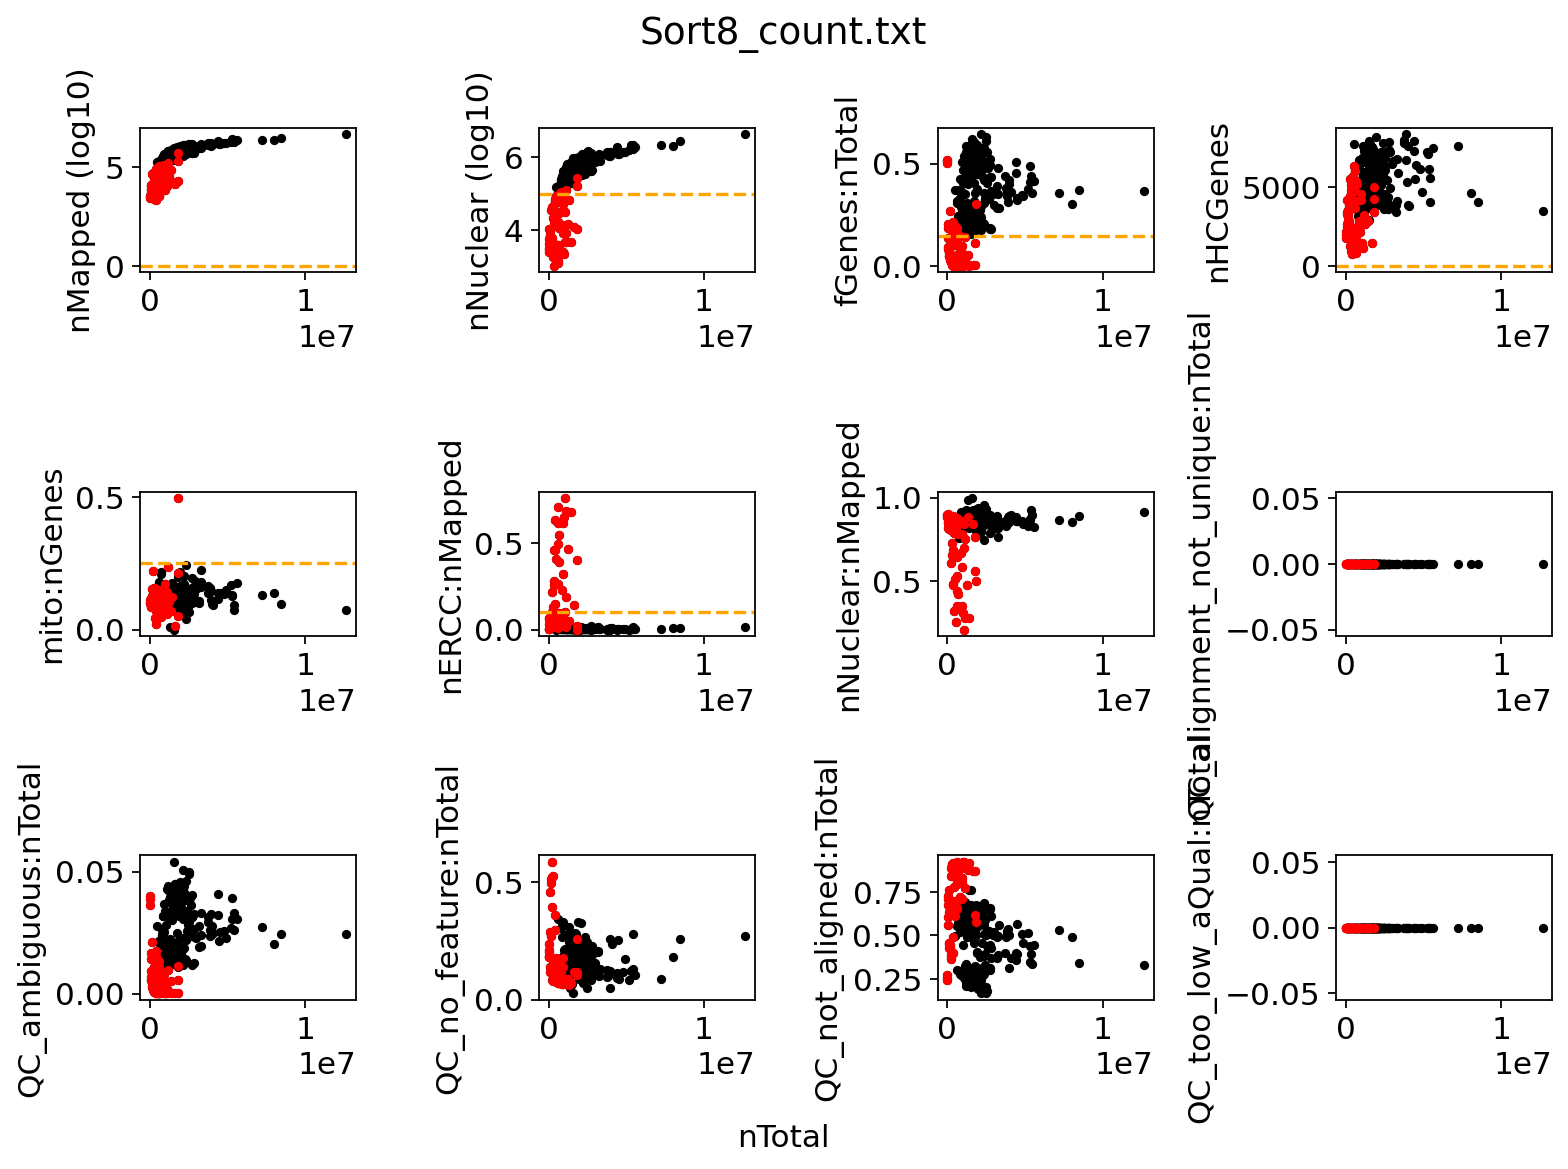

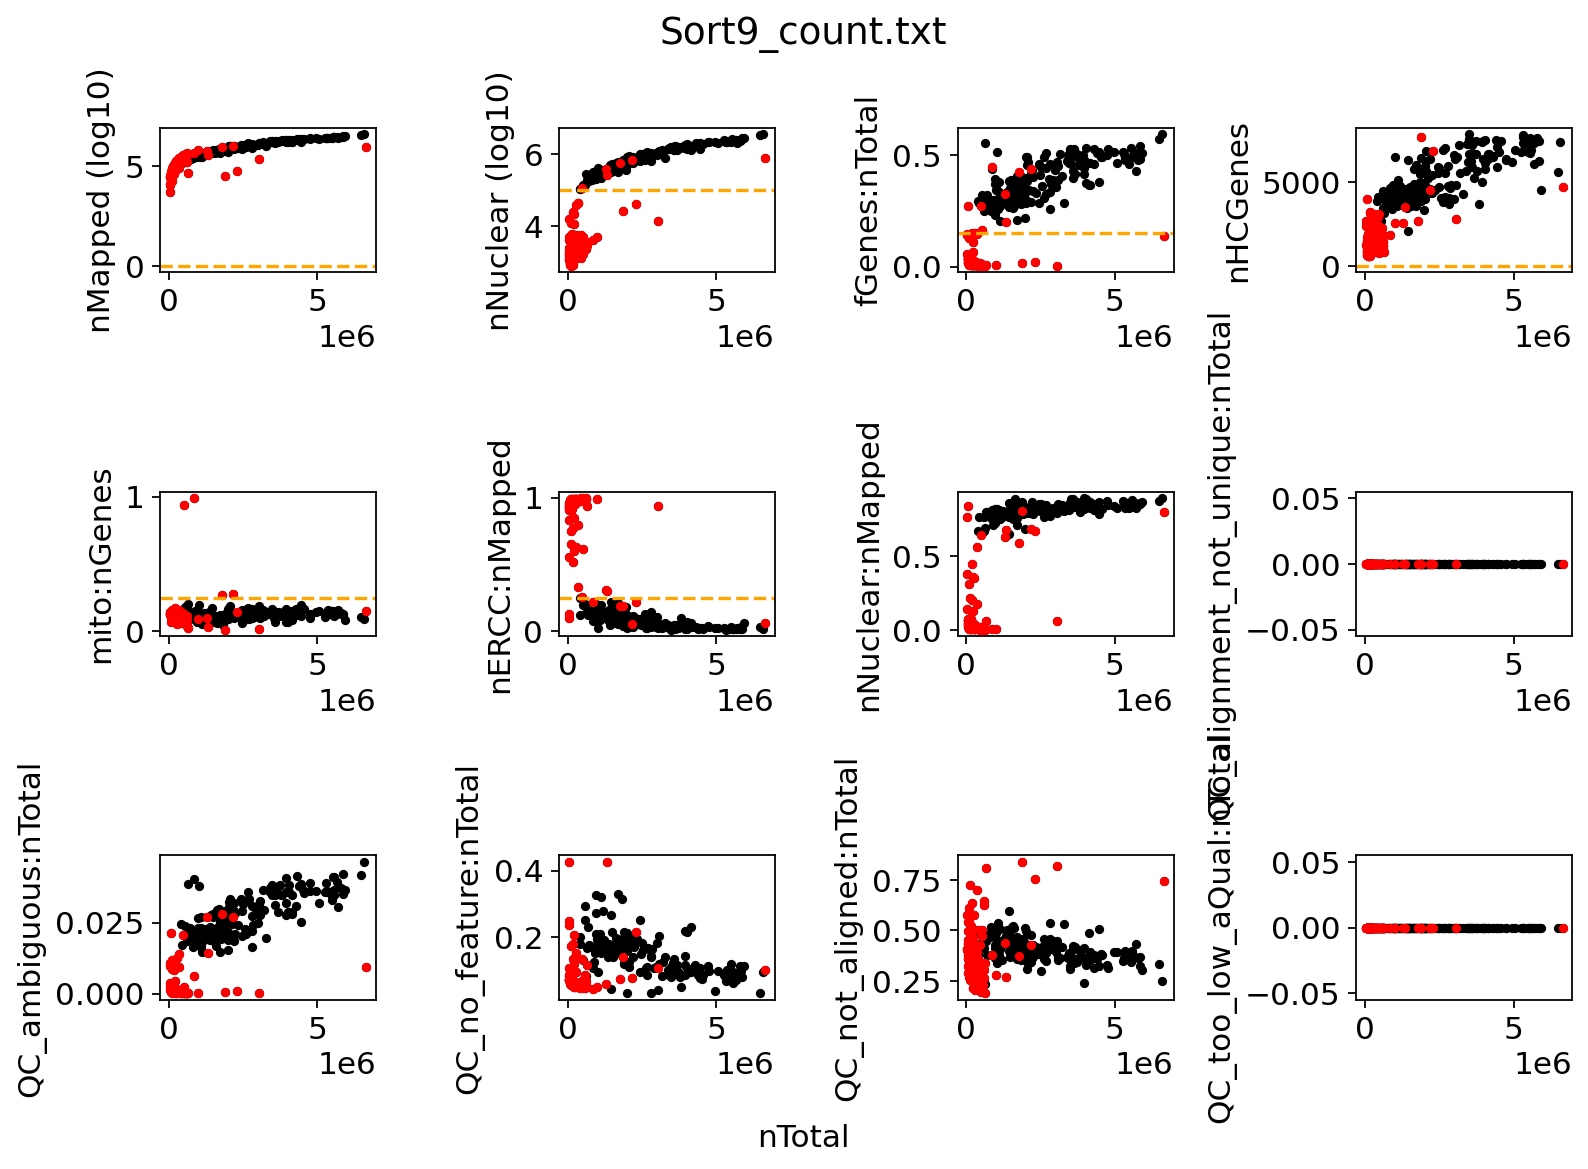

In [11]:
adata = []
for i in range(len(folder_list)):
    print(folder_list[i])
    adata_sub = smqpp.read_in_files(Indir+folder_list[i], ftable_loc, method='HTSeqcount')
    adata_sub.obs['eGFP'] = adata_sub[:,'eGFP'].X.flatten()
    adata_sub = adata_sub[:, adata_sub.var_names != 'eGFP'].copy()
    adata_sub.var_names_make_unique()
    adata_sub = smqpp.smartseq_qc(adata_sub,cutoff=cutoff[i], title=folder_list[i], MTpattern='MT-')
    adata.append(adata_sub)
    del adata_sub

In [12]:
# combine data
adata = anndata.AnnData.concatenate(adata[0], adata[1], adata[2])
adata.obs_names = [x[:-2] for x in adata.obs_names]
# add in meta
adata.obs = pd.concat([adata.obs, meta], axis=1, join='inner')

In [13]:
adata

AnnData object with n_obs × n_vars = 634 × 65988 
    obs: 'QC_alignment_not_unique', 'QC_ambiguous', 'QC_no_feature', 'QC_not_aligned', 'QC_too_low_aQual', 'batch', 'eGFP', 'n_counts', 'n_genes', 'percent_mito', 'Gottgens_ID_RBGxxx', 'CRI_identifier', 'CRI_run', 'Plate_number', 'Position_in_96_well_plate_sorted', 'Position_in_96_well_plate_RNA_seq', 'FACs_index_data', 'BGI_code', 'Sample_name', 'Details', 'Cell_type_general', 'Cell_type_subtype', 'Expected_cell_number_for_10x_genomics', 'Owner', 'Species', 'Index', 'CI_annotation_of_index', 'Index_name_in_library_Set', 'Average_Library_Length_bp', 'Average_library_length_bp', 'Pool_size', 'Number_of_lanes', 'Number_of_additional_lanes_ordered_i_e_repeats', 'Paid_Y_N', 'Invoice_number', 'Price', 'Cell_Type', 'Day', 'Condition', 'Batch', 'ID'
    var: 'Gene Name', 'Gene Type', 'Ensembl_ID'
    obsm: 'ERCC'

In [16]:
adata.write('./write/BM789_raw.h5ad')

# Normalisation

In [17]:
adata =sc.read('./write/BM789_raw.h5ad')

In [18]:
sc.pp.filter_genes(adata, min_cells=1)

filtered out 22270 genes that are detected in less than 1 cells


In [19]:
smqpp.normalise_data(adata)

Calculate SF for genes:
Filtered matrix shape: (634, 184)
Number of valid means:184
Calculate SF for erccs:
Filtered matrix shape: (634, 4)
Number of valid means:4


In [20]:
adata.raw = adata

In [21]:
adata.write('./write/BM789_lognorm_afterQC.h5ad')

# Check for Cell Cycle

In [22]:
adata = sc.read('./write/BM789_lognorm_afterQC.h5ad')
adata.var_names_make_unique()

In [23]:
sc.pp.scale(adata)

In [24]:
cell_cycle_genes = [x.strip() for x in open('/home/xw251/rds/rds-bg200-hphi-gottgens/users/xw251/Files/regev_lab_cell_cycle_genes.txt')]

In [25]:
print(len(cell_cycle_genes))

97


In [26]:
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = np.intersect1d(cell_cycle_genes, adata.var_names)
print(len(s_genes))
print(len(g2m_genes))
print(len(cell_cycle_genes))

43
54
96


In [27]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs) (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs) (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


In [28]:
adata.obs['phase'].value_counts()

G1     304
S      222
G2M    108
Name: phase, dtype: int64

In [29]:
# save cell cycle results
np.savetxt('phase.txt', adata.obs['phase'], delimiter='\t', fmt='%s')
np.savetxt('S_score.txt', adata.obs['S_score'], delimiter='\t')
np.savetxt('G2M_score.txt', adata.obs['G2M_score'], delimiter='\t')

# Check for GFP

In [30]:
adata = sc.read('./write/BM789_lognorm_afterQC.h5ad')
adata.var_names_make_unique()

In [31]:
adata.obs['con_comb'] = adata.obs['Day'].astype(str)+'_'+adata.obs['Cell_Type'].astype(str)+'_'+adata.obs['Condition'].astype(str)
adata.obs['con_comb'].value_counts().sort_index()

Day0_CD34+_NT       64
Day0_LT-HSC_NT      82
Day0_ST-HSC_NT      82
Day3_CD34+_GFP-     57
Day3_CD34+_T        63
Day3_LT-HSC_GFP-    70
Day3_LT-HSC_T       70
Day3_ST-HSC_GFP-    74
Day3_ST-HSC_T       72
Name: con_comb, dtype: int64

In [32]:
adata.obs['eGFP_norm'] = np.log1p(adata.obs['eGFP']/adata.obs['sf_gene'])

In [33]:
df_temp = adata.obs[['con_comb','eGFP', 'eGFP_norm', 'Day', 'Cell_Type', 'Condition']]

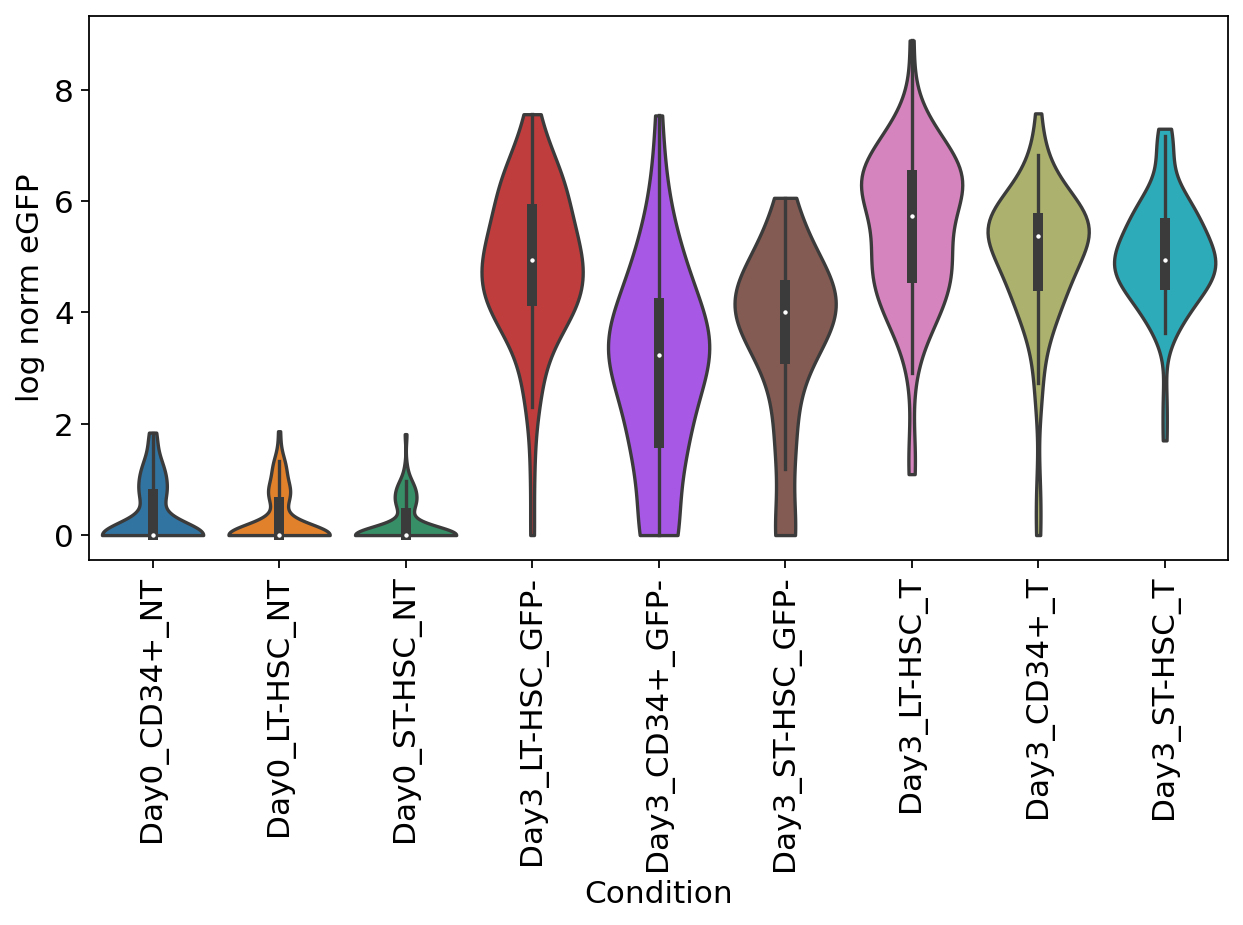

In [35]:
import seaborn as sns
plt.figure(figsize=(8,6))
ax = sns.violinplot(x='con_comb', y='eGFP_norm', data=df_temp, cut=0, scale='width')
ax.grid(False)
ax.set_xlabel('Condition')
ax.set_ylabel('log norm eGFP')
plt.xticks(rotation='90')
plt.tight_layout()
plt.savefig('./figures/Violinplot_GFP_norm.pdf')

In [36]:
tab1 = pd.crosstab( df_temp['con_comb'] ,df_temp['eGFP_norm'] >0, normalize=0)*100
tab1.columns = ['GFP=0', 'GFP>0']
tab1.to_csv('Table_concombvsGFP_norm.csv')

In [37]:
tab1

GFP=0       GFP>0
con_comb                               
Day0_CD34+_NT     65.625000   34.375000
Day0_LT-HSC_NT    68.292683   31.707317
Day0_ST-HSC_NT    70.731707   29.268293
Day3_CD34+_GFP-   14.035088   85.964912
Day3_CD34+_T       1.587302   98.412698
Day3_LT-HSC_GFP-   1.428571   98.571429
Day3_LT-HSC_T      0.000000  100.000000
Day3_ST-HSC_GFP-   9.459459   90.540541
Day3_ST-HSC_T      0.000000  100.000000

In [38]:
adata.write('./write/BM789_lognorm_afterQC.h5ad')

... storing 'con_comb' as categorical


# Subset HVGs

In [39]:
adata = sc.read('./write/BM789_lognorm_afterQC.h5ad')

In [40]:
adata.obs['phase'] = np.genfromtxt('phase.txt', delimiter='\t', dtype=str)
adata.obs['S_score'] = np.genfromtxt('S_score.txt', delimiter='\t')
adata.obs['G2M_score'] = np.genfromtxt('G2M_score.txt', delimiter='\t')

In [43]:
# ERCC is too low, could not use to fit
smqpp.tech_var(adata, useERCC=False, meanForFit=10) 

MeanForFit:  10
8993
Length of HVGs: 2874


/home/xw251/miniconda3/envs/scanpy_py368/lib/python3.6/site-packages/statsmodels/genmod/generalized_linear_model.py:278: DomainWarning: The identity link function does not respect the domain of the Gamma family.
  DomainWarning)


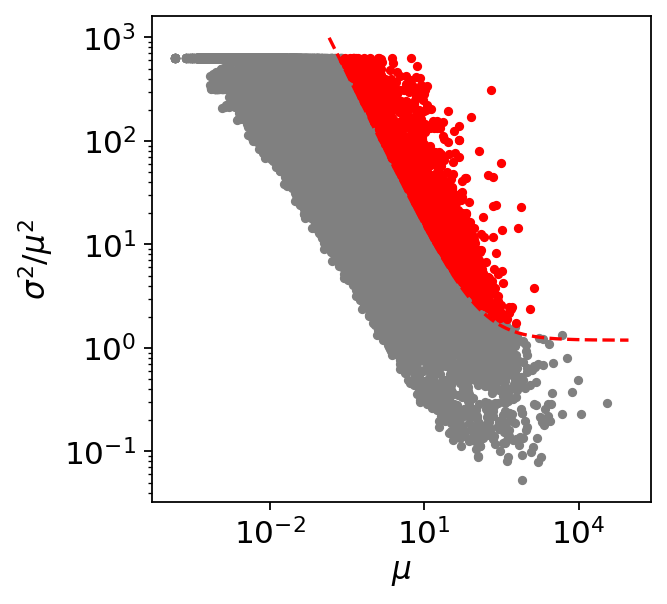

In [44]:
smqpp.plot_tech_var(adata)

In [46]:
adata.shape

(634, 43718)

In [47]:
adata = adata[:,adata.uns['varGenes']['genes']['highVar']].copy()

In [48]:
adata.shape

(634, 2874)

In [49]:
# scale for pca
sc.pp.scale(adata)

In [50]:
adata.obs['Batch'].value_counts().sort_index()

S07    248
S08    216
S09    170
Name: Batch, dtype: int64

# Visualisation

computing PCA with n_comps = 50
    finished (0:00:00)


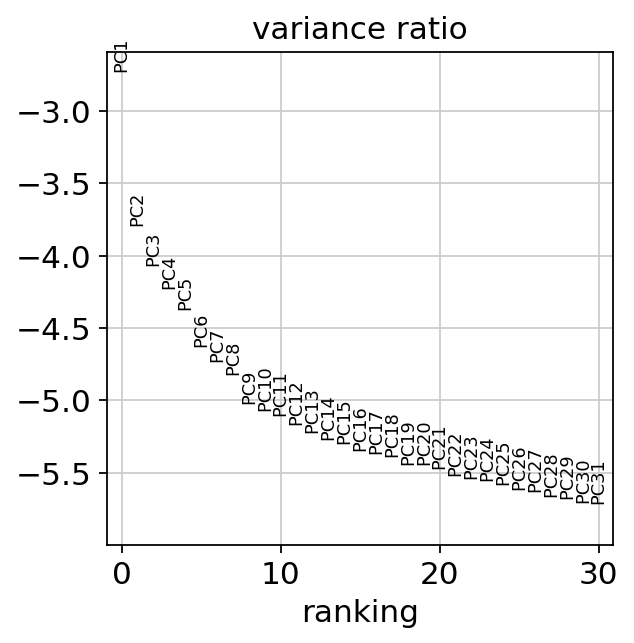

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)
computing tSNE
    using 'X_pca' with n_pcs = 50
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:03)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:02)


In [54]:
sc.tl.pca(adata,svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)
sc.pp.neighbors(adata, n_neighbors=10)
sc.tl.umap(adata)
sc.tl.tsne(adata)
sc.tl.draw_graph(adata)

In [55]:
adata.write('./write/BM789_processed.h5ad')

... storing 'phase' as categorical


## Plot them out

In [56]:
adata = sc.read('./write/BM789_processed.h5ad')

In [57]:
# Carys would like to change Day variable
adata.obs['Day'] = adata.obs['Day'].astype('category')
adata.obs['Day'] = adata.obs['Day'].cat.rename_categories(['0hr', '62hr'])

In [60]:
main_keys = ['Day', 'Cell_Type', 'Condition', 'Plate_number', 'Batch',
            'n_counts', 'n_genes', 'eGFP_norm', 'phase']

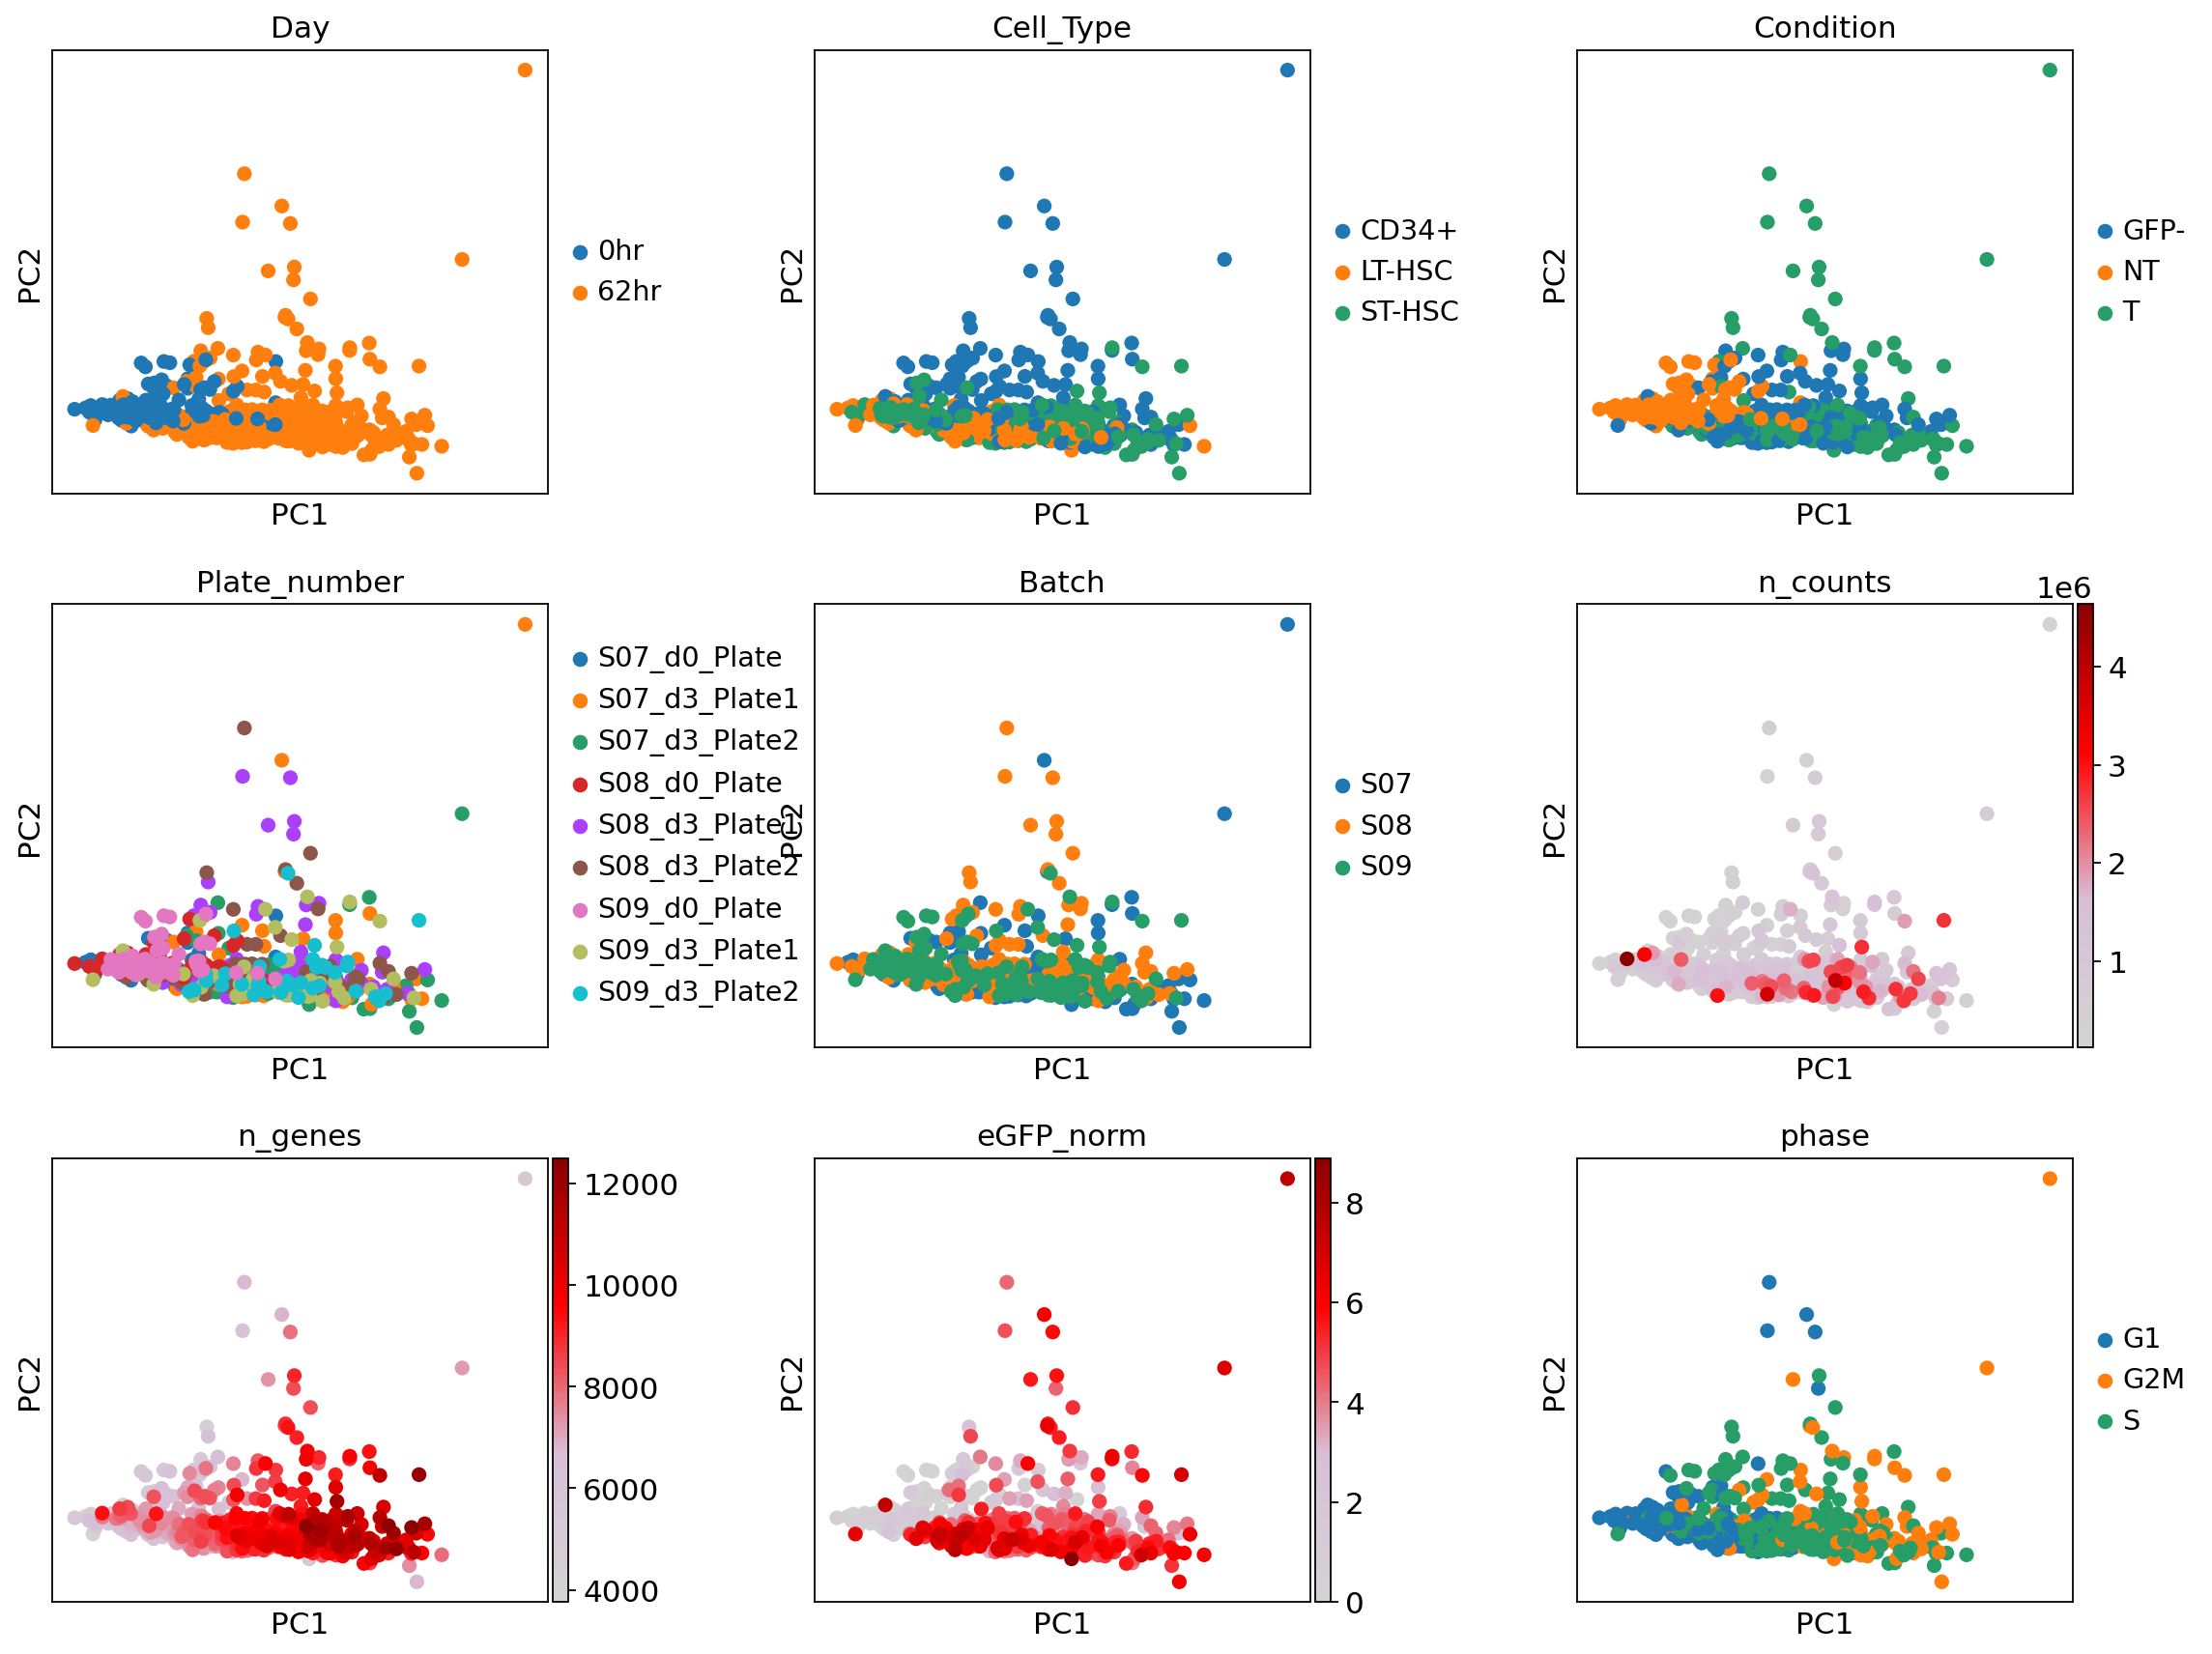

In [70]:
sc.pl.pca_scatter(adata, color=main_keys, wspace=0.4, ncols=3, color_map=cmap, save='_BM789.pdf')

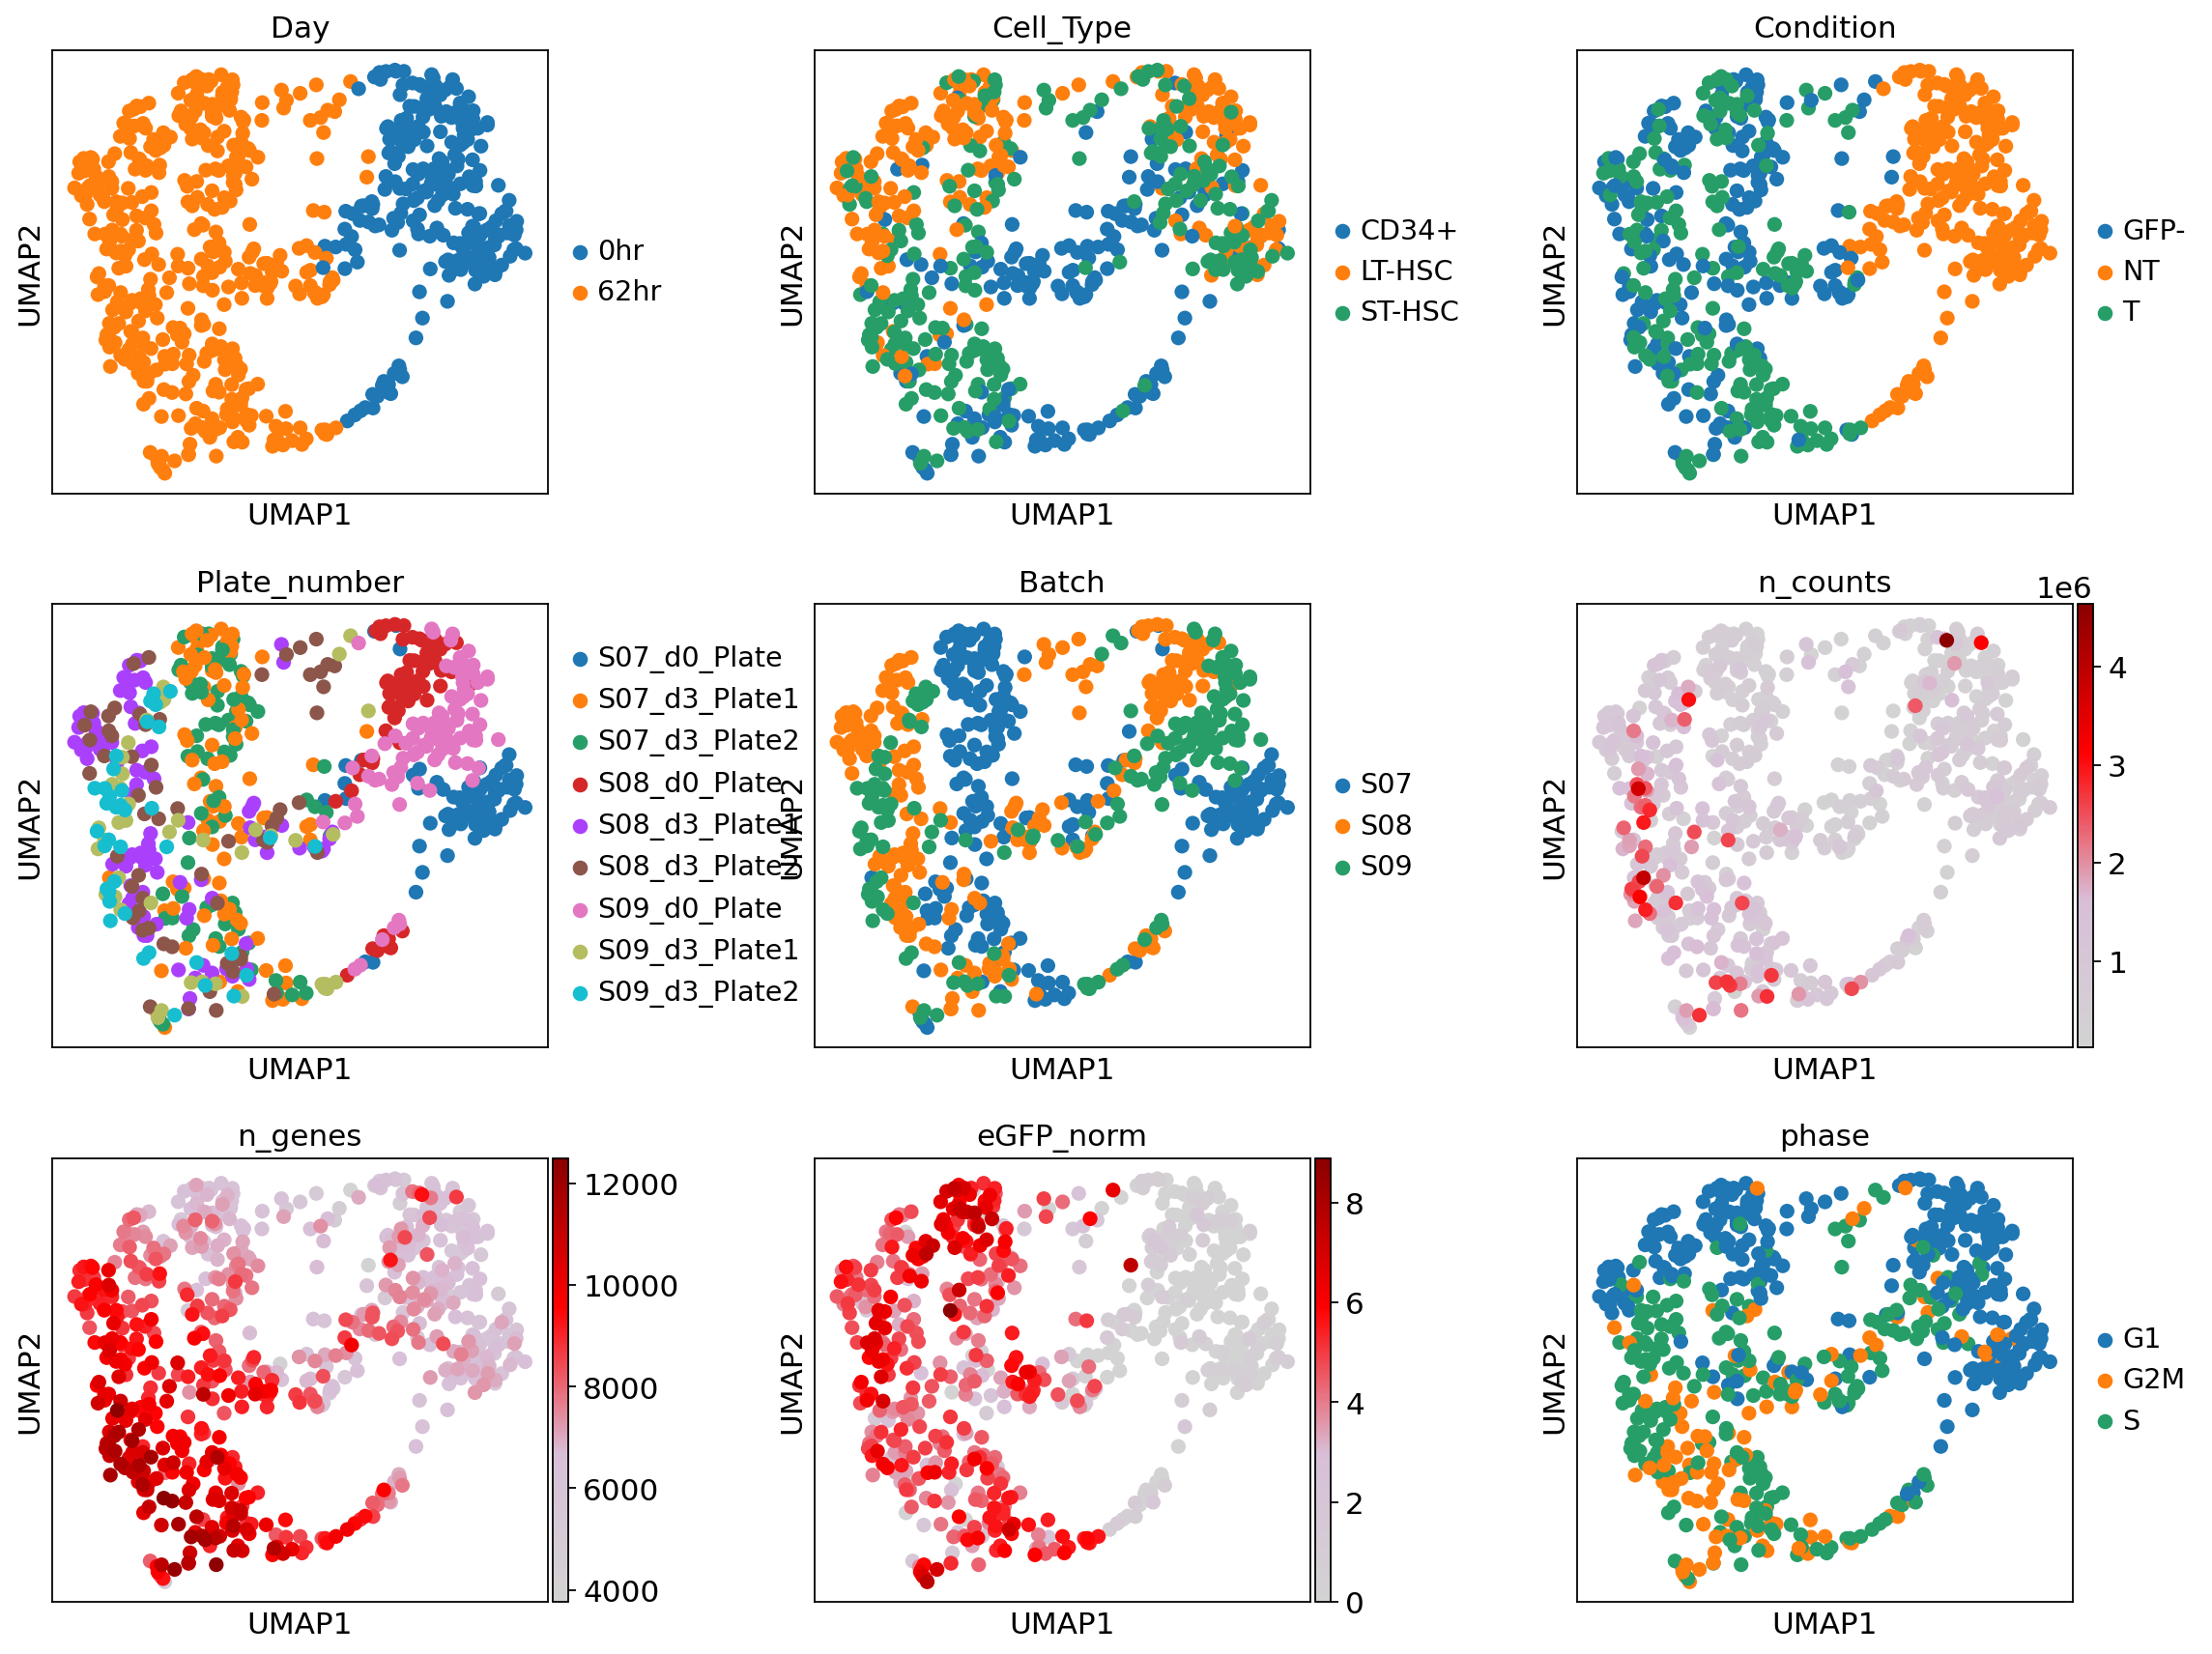

In [71]:
sc.pl.umap(adata, color=main_keys, wspace=0.4, ncols=3, color_map=cmap, save='_BM789.pdf')

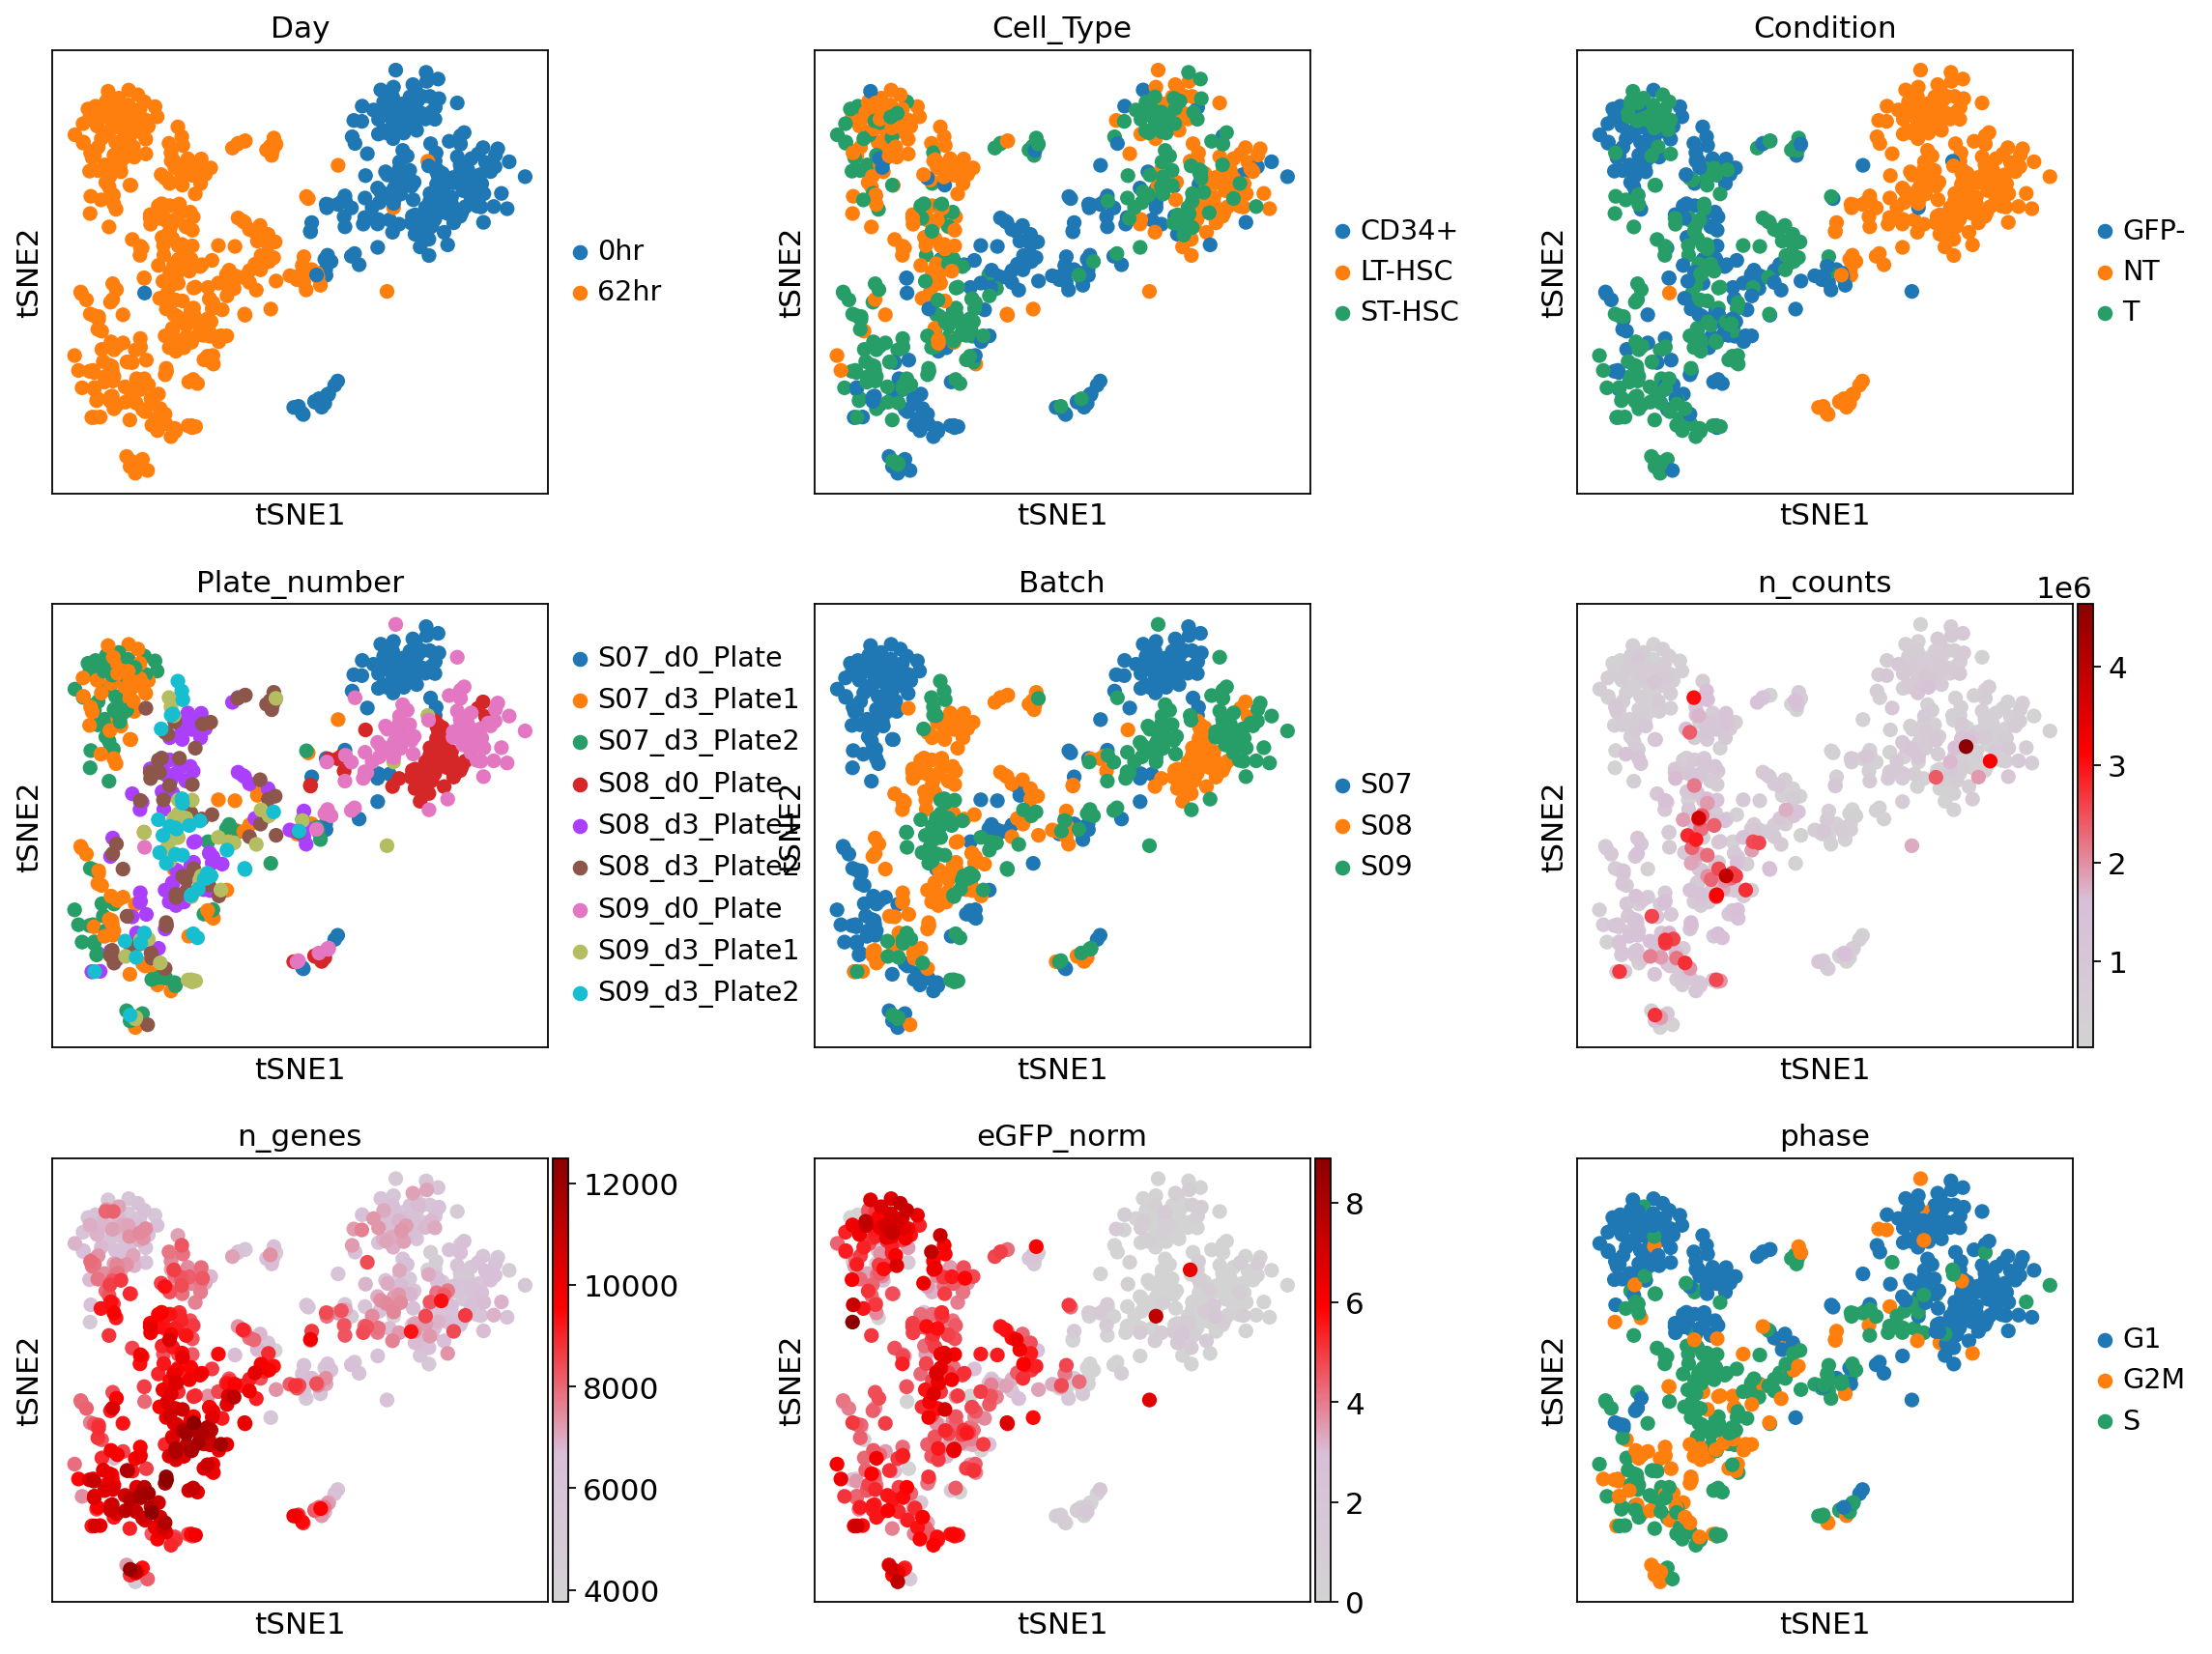

In [72]:
sc.pl.tsne(adata, color=main_keys, wspace=0.4, ncols=3, color_map=cmap, save='_BM789.pdf')

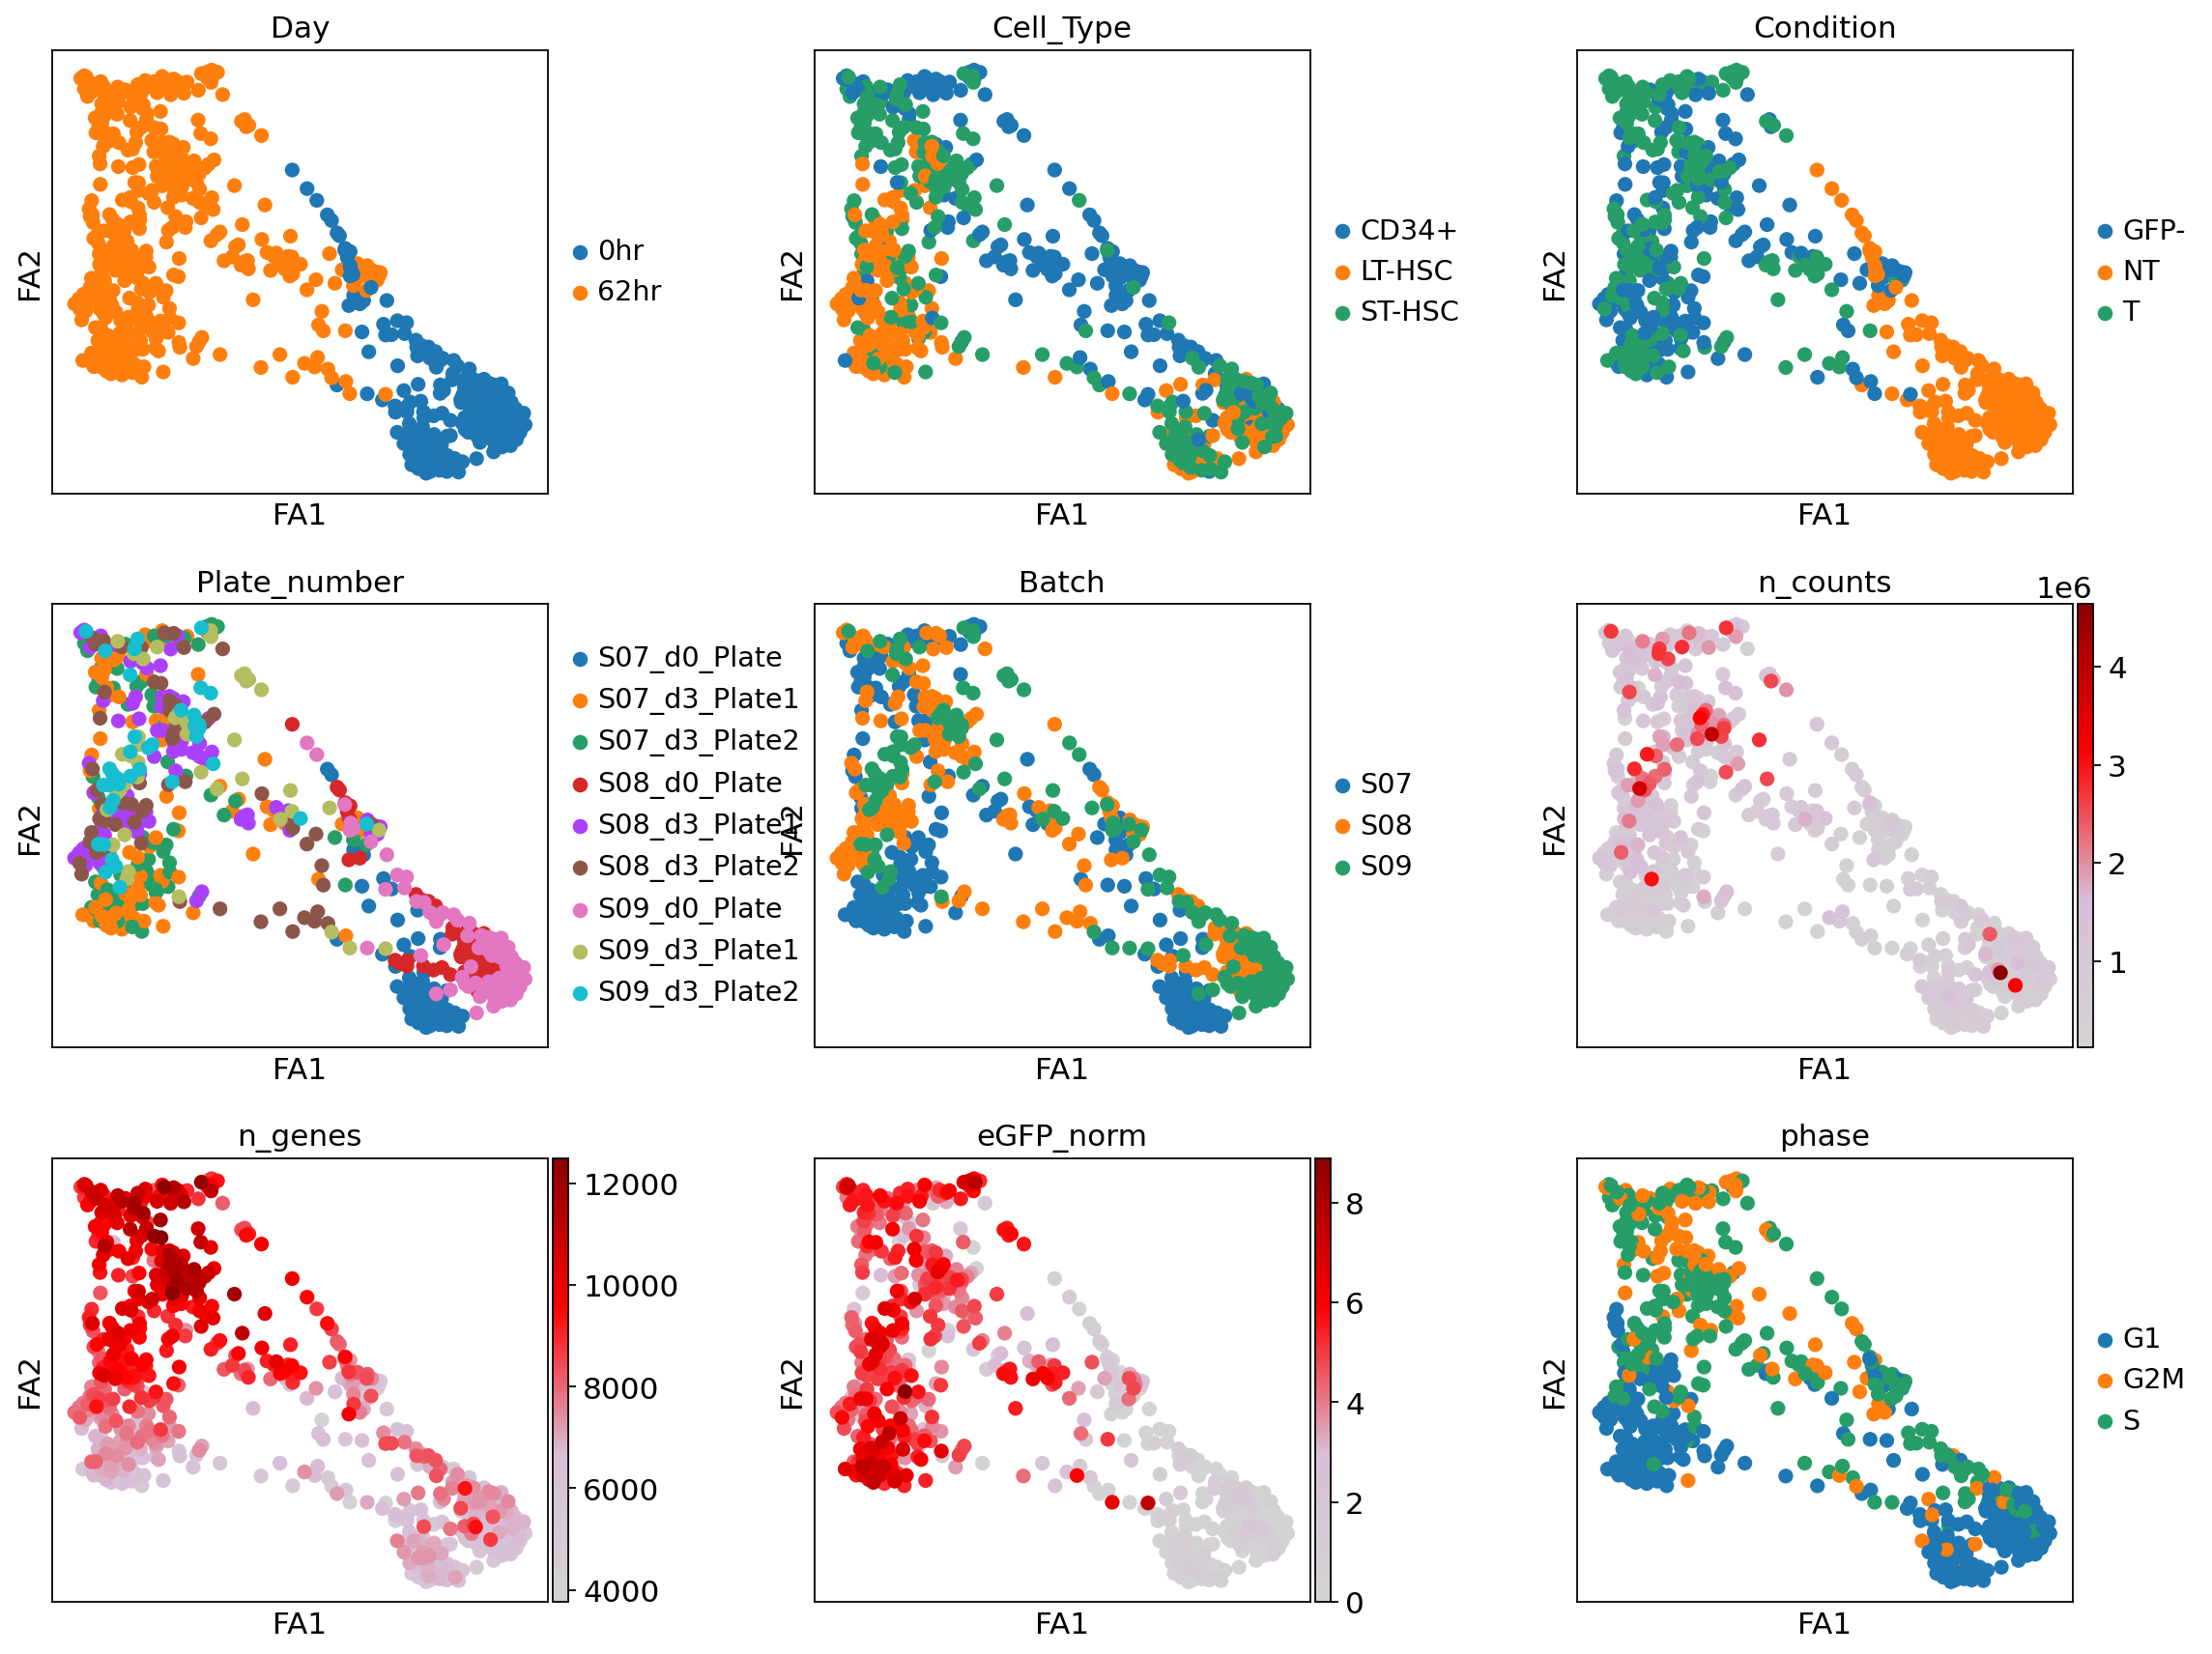

In [73]:
sc.pl.draw_graph(adata, color=main_keys, wspace=0.4, ncols=3, color_map=cmap, save='_BM789.pdf')

In [65]:
adata.write('./write/BM789_processed.h5ad')

# Split data

In [66]:
adata = sc.read('./write/BM789_processed.h5ad')
adata_raw = sc.read('./write/BM789_raw.h5ad')
adata_raw.obs = adata.obs
adata_day0 = adata_raw[adata_raw.obs['Day'] == '0hr', :].copy()
adata_day3 = adata_raw[adata_raw.obs['Day'] == '62hr', :].copy()
adata_day0.write('./write/BM789_raw_Day0.h5ad')
adata_day3.write('./write/BM789_raw_Day3.h5ad')

In [67]:
adata_day0

AnnData object with n_obs × n_vars = 228 × 65988 
    obs: 'QC_alignment_not_unique', 'QC_ambiguous', 'QC_no_feature', 'QC_not_aligned', 'QC_too_low_aQual', 'batch', 'eGFP', 'n_counts', 'n_genes', 'percent_mito', 'Gottgens_ID_RBGxxx', 'CRI_identifier', 'CRI_run', 'Plate_number', 'Position_in_96_well_plate_sorted', 'Position_in_96_well_plate_RNA_seq', 'FACs_index_data', 'BGI_code', 'Sample_name', 'Details', 'Cell_type_general', 'Cell_type_subtype', 'Expected_cell_number_for_10x_genomics', 'Owner', 'Species', 'Index', 'CI_annotation_of_index', 'Index_name_in_library_Set', 'Average_Library_Length_bp', 'Average_library_length_bp', 'Pool_size', 'Number_of_lanes', 'Number_of_additional_lanes_ordered_i_e_repeats', 'Paid_Y_N', 'Invoice_number', 'Price', 'Cell_Type', 'Day', 'Condition', 'Batch', 'ID', 'sf_gene', 'sf_ercc', 'con_comb', 'eGFP_norm', 'phase', 'S_score', 'G2M_score'
    var: 'Gene Name', 'Gene Type', 'Ensembl_ID'
    obsm: 'ERCC'

In [68]:
adata_day3

AnnData object with n_obs × n_vars = 406 × 65988 
    obs: 'QC_alignment_not_unique', 'QC_ambiguous', 'QC_no_feature', 'QC_not_aligned', 'QC_too_low_aQual', 'batch', 'eGFP', 'n_counts', 'n_genes', 'percent_mito', 'Gottgens_ID_RBGxxx', 'CRI_identifier', 'CRI_run', 'Plate_number', 'Position_in_96_well_plate_sorted', 'Position_in_96_well_plate_RNA_seq', 'FACs_index_data', 'BGI_code', 'Sample_name', 'Details', 'Cell_type_general', 'Cell_type_subtype', 'Expected_cell_number_for_10x_genomics', 'Owner', 'Species', 'Index', 'CI_annotation_of_index', 'Index_name_in_library_Set', 'Average_Library_Length_bp', 'Average_library_length_bp', 'Pool_size', 'Number_of_lanes', 'Number_of_additional_lanes_ordered_i_e_repeats', 'Paid_Y_N', 'Invoice_number', 'Price', 'Cell_Type', 'Day', 'Condition', 'Batch', 'ID', 'sf_gene', 'sf_ercc', 'con_comb', 'eGFP_norm', 'phase', 'S_score', 'G2M_score'
    var: 'Gene Name', 'Gene Type', 'Ensembl_ID'
    obsm: 'ERCC'

In [69]:
pd.crosstab(adata.obs['CRI_identifier'], adata.obs['Batch'])

Batch           S07  S08  S09
CRI_identifier               
SLX-11524         0  151    0
SLX-12952         0    0   81
SLX-12953         0   65   89
SLX_11473        74    0    0
SLX_11474       174    0    0

# Differential expression analysis

As many factors were included in the analysis, thus we need to use linear models to account for these effects. Here switch again to R for DESeq2 package.

The following comparisons will be done:

**BM+MPB:**

Day0 LT-HSC marker genes:
1. LT-HSC_Day0_NT vs the_rest
2. LT-HSC_Day0_NT vs ST-HSC_Day0_NT

**MPB:**

Day3 LT-HSC marker genes:
1. LT-HSC_Day3_NT vs the_rest

**MB:**
Day3 LT-HSC marker genes:
1. LT-HSC_Day3_GFP- vs rest

**BM+MPB:**

Day3 GFP+ vs Day3 GFP-:
1. Day3_GFP+PD- vs Day3_GFP-PD-
	- LT-HSC_Day3_GFP+PD- vs LT-HSC_Day3_GFP-PD-

**MPB only:**

Day3 GFP- vs Day3 NT:
1. Day3_GFP-PD- vs Day3_NT
	- LT-HSC_Day3_GFP-PD- vs LT-HSC_Day3_NT
	- ST-HSC_Day3_GFP-PD- vs ST-HSC_Day3_NT

**MPB only:**

Day3 GFP+ vs Day3 NT:
1. Day3_GFP+PD- vs Day3_NT
	- LT-HSC_Day3_GFP+PD- vs LT-HSC_Day3_NT
	- ST-HSC_Day3_GFP+PD- vs ST-HSC_Day3_NT
	- CD34_Day3_GFP+PD- vs CD34_Day3_NT

**MPB only:**

Day3 LT_PD+ vs Day3 LT_PD-:
1. LT_Day3_PD+ vs LT_Day3_PD-
	- LT-HSC_Day3_GFP+PD+ vs LT-HSC_Day3_GFP+PD-
	- LT-HSC_Day3_GFP-PD+ vs LT-HSC_Day3_GPF-PD-

Day3 vs Day0:
1. Day3 vs Day0

    **MPB only:**

	- Day3 NT vs Day0_NT
		- CD34_Day3_NT vs CD34_Day0_NT
	 	- LT-HSC_Day3_NT vs LT-HSC_Day0_NT
	 	- ST-HSC_Day3_NT vs ST-HSC_Day0_NT

    **BM only:**
    - Day3 GFP- vs Day0 NT
        - CD34_Day3_GFP- vs CD34_Day0_NT
        - LT-HSC_Day3_GFP- vs LT-HSC_Day0_NT
        - ST-HSC_Day3_GFP- vs ST-HSC_Day0_NT

In [2]:
%reload_ext rpy2.ipython

In [3]:
adata = sc.read('./write/BM789_raw.h5ad')
count = adata.X
GN = adata.var_names
adata = sc.read('./write/BM789_processed.h5ad')
meta = adata.obs

In [4]:
count = pd.DataFrame(count.transpose())
count.index = GN
count.columns = adata.obs_names

In [5]:
con_sub1 = {'T': 'GFP_pos',
           'GFP-': 'GFP_neg',
           'NT': 'NT'}

meta['con_sub1'] = [con_sub1[x] for x in meta['Condition'].values]

In [ ]:
%%R -i count -i meta
source("../MPB1234/DESeq_source.R")

## Day0 LT-HSC marker genes ###########################################
print("Day0 LT-HSC marker genes")
g1 <- meta$ID[meta$Cell_Type == "LT-HSC" & meta$Day == "0hr" & meta$Condition == "NT"]
g2 <- meta$ID[meta$Cell_Type != "LT-HSC" & meta$Day == "0hr" & meta$Condition == "NT"]
print(length(g1))
print(length(g2))
LT_Day0_NTvsRest_Day0_NT <- doDESeq(count, meta, group1=g1, group2=g2, fdr=0.1, batchmodel="~n_genes+batch")
saveDEresults(LT_Day0_NTvsRest_Day0_NT, "./LT_Day0_NTvsRest_Day0_NT")
saveRDS(LT_Day0_NTvsRest_Day0_NT, file="./LT_Day0_NTvsRest_Day0_NT.rds")
print(summary(LT_Day0_NTvsRest_Day0_NT))

## Day0 LT-HSC marker genes #################################################
print("Day0 LT-HSC marker genes")
g1 <- meta$ID[meta$Cell_Type == "LT-HSC" & meta$Day == "0hr" & meta$Condition == "NT"]
g2 <- meta$ID[meta$Cell_Type == "ST-HSC" & meta$Day == "0hr" & meta$Condition == "NT"]
print(length(g1))
print(length(g2))
LT_Day0_NTvsST_Day0_NT <- doDESeq(count, meta, group1=g1, group2=g2, fdr=0.1, batchmodel="~n_genes+batch")
saveDEresults(LT_Day0_NTvsST_Day0_NT, "./LT_Day0_NTvsST_Day0_NT")
saveRDS(LT_Day0_NTvsST_Day0_NT, file="./LT_Day0_NTvsST_Day0_NT.rds")
print(summary(LT_Day0_NTvsST_Day0_NT))

## Day3 GFP+ vs Day3 GFP- #########################################################
print("Day3 GFP+ vs Day3 GFP-")
g1 <- meta$ID[meta$con_sub1 == "GFP_pos" & meta$Day == "62hr"]
g2 <- meta$ID[meta$con_sub1 == "GFP_neg" & meta$Day == "62hr"]
print(length(g1))
print(length(g2))
Day3_GFPposvsDay3_GFPneg <- doDESeq(count, meta, group1=g1, group2=g2, fdr=0.1, batchmodel="~n_genes+batch+Cell_Type")
saveDEresults(Day3_GFPposvsDay3_GFPneg, "./Day3_GFPposvsDay3_GFPneg")
saveRDS(Day3_GFPposvsDay3_GFPneg, file="./Day3_GFPposvsDay3_GFPneg.rds")
print(summary(Day3_GFPposvsDay3_GFPneg))

## Day3 vs Day0
print("Day3 vs Day0")
g1 <- meta$ID[meta$Day == "62hr" & meta$con_sub1 != "GFP_pos"]
g2 <- meta$ID[meta$Day == "0hr" & meta$con_sub1 != "GFP_pos"]
print(length(g1))
print(length(g2))
Day3vsDay0 <- doDESeq(count, meta, group1=g1, group2=g2, fdr=0.1, batchmodel="~n_genes+batch+Cell_Type")
saveDEresults(Day3vsDay0, "./Day3vsDay0")
saveRDS(Day3vsDay0, file="./Day3vsDay0.rds")
print(summary(Day3vsDay0))

In [13]:
%%R -i count -i meta
source("../MPB1234/DESeq_source.R")

## Day3 LT-HSC marker genes ###########################################
print("Day3 LT-HSC marker genes")
g1 <- meta$ID[meta$Cell_Type == "LT-HSC" & meta$Day == "62hr" & meta$con_sub1 == "GFP_neg"]
g2 <- meta$ID[meta$Cell_Type != "LT-HSC" & meta$Day == "62hr" & meta$con_sub1 == "GFP_neg"]
print(length(g1))
print(length(g2))
LT_Day3_GFPnegvsRest_Day3_GFPneg <- doDESeq(count, meta, group1=g1, group2=g2, fdr=0.1, batchmodel="~n_genes+batch")
saveDEresults(LT_Day3_GFPnegvsRest_Day3_GFPneg, "./LT_Day3_GFPnegvsRest_Day3_GFPneg")
saveRDS(LT_Day3_GFPnegvsRest_Day3_GFPneg, file="./LT_Day3_GFPnegvsRest_Day3_GFPneg.rds")
print(summary(LT_Day3_GFPnegvsRest_Day3_GFPneg))

## Day3 GFP+ vs Day3 GFP- sub ####################################
print("Day3 LT GFP+ vs Day3 LT GFP-")
g1 <- meta$ID[meta$con_sub1 == "GFP_pos" & meta$Day == "62hr" & meta$Cell_Type=="LT-HSC"]
g2 <- meta$ID[meta$con_sub1 == "GFP_neg" & meta$Day == "62hr" & meta$Cell_Type=="LT-HSC"]
print(length(g1))
print(length(g2))
LT_Day3_GFPposvsLT_Day3_GFPneg <- doDESeq(count, meta, group1=g1, group2=g2, fdr=0.1, batchmodel="~n_genes+batch")
saveDEresults(LT_Day3_GFPposvsLT_Day3_GFPneg, "./LT_Day3_GFPposvsLT_Day3_GFPneg")
saveRDS(LT_Day3_GFPposvsLT_Day3_GFPneg, file="./LT_Day3_GFPposvsLT_Day3_GFPneg.rds")
print(summary(LT_Day3_GFPposvsLT_Day3_GFPneg))

## Day3 GFP- vs Day0 NT sub ############################################
print("LT Day3 GFP- vs LT Day0 NT")
g1 <- meta$ID[meta$Day == "62hr" & meta$con_sub1 != "GFP_pos" & meta$Cell_Type=="LT-HSC"]
g2 <- meta$ID[meta$Day == "0hr" & meta$con_sub1 != "GFP_pos" & meta$Cell_Type=="LT-HSC"]
print(length(g1))
print(length(g2))
LT_Day3_GFPnegvsLT_Day0_NT <- doDESeq(count, meta, group1=g1, group2=g2, fdr=0.1, batchmodel="~n_genes+batch")
saveDEresults(LT_Day3_GFPnegvsLT_Day0_NT, "./LT_Day3_GFPnegvsLT_Day0_NT")
saveRDS(LT_Day3_GFPnegvsLT_Day0_NT, file="./LT_Day3_GFPnegvsLT_Day0_NT.rds")
print(summary(LT_Day3_GFPnegvsLT_Day0_NT))

print("ST Day3 GFP- vs ST Day0 NT")
g1 <- meta$ID[meta$Day == "62hr" & meta$con_sub1 != "GFP_pos" & meta$Cell_Type=="ST-HSC"]
g2 <- meta$ID[meta$Day == "0hr" & meta$con_sub1 != "GFP_pos" & meta$Cell_Type=="ST-HSC"]
print(length(g1))
print(length(g2))
ST_Day3_GFPnegvsST_Day0_NT <- doDESeq(count, meta, group1=g1, group2=g2, fdr=0.1, batchmodel="~n_genes+batch")
saveDEresults(ST_Day3_GFPnegvsST_Day0_NT, "./ST_Day3_GFPnegvsST_Day0_NT")
saveRDS(ST_Day3_GFPnegvsST_Day0_NT, file="./ST_Day3_GFPnegvsST_Day0_NT.rds")
print(summary(ST_Day3_GFPnegvsST_Day0_NT))

print("CD34 Day3 GFP- vs CD34 Day0 NT")
g1 <- meta$ID[meta$Day == "62hr" & meta$con_sub1 != "GFP_pos" & meta$Cell_Type=="CD34+"]
g2 <- meta$ID[meta$Day == "0hr" & meta$con_sub1 != "GFP_pos" & meta$Cell_Type=="CD34+"]
print(length(g1))
print(length(g2))
CD34_Day3_GFPnegvsCD34_Day0_NT <- doDESeq(count, meta, group1=g1, group2=g2, fdr=0.1, batchmodel="~n_genes+batch")
saveDEresults(CD34_Day3_GFPnegvsCD34_Day0_NT, "./CD34_Day3_GFPnegvsCD34_Day0_NT")
saveRDS(CD34_Day3_GFPnegvsCD34_Day0_NT, file="./CD34_Day3_GFPnegvsCD34_Day0_NT.rds")
print(summary(CD34_Day3_GFPnegvsCD34_Day0_NT))

[1] "Day3 LT-HSC marker genes"
[1] 70
[1] 131


R[write to console]: converting counts to integer mode

R[write to console]:   the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

R[write to console]:   the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  it is generally a good idea to center and scale numeric variables in the design
  to improve GLM convergence.

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was a

[1] "Intercept"                 "n_genes"                  
[3] "batch_1_vs_0"              "batch_2_vs_0"             
[5] "condition_test_vs_control"
                  Length Class        Mode     
DESeq                 6  DESeqResults S4       
upGene              355  -none-       character
downGene            724  -none-       character
backgroundGeneSet 13098  -none-       character
[1] "Day3 LT GFP+ vs Day3 LT GFP-"
[1] 70
[1] 70


R[write to console]: converting counts to integer mode

R[write to console]:   the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

R[write to console]:   the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  it is generally a good idea to center and scale numeric variables in the design
  to improve GLM convergence.

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was a

[1] "Intercept"                 "n_genes"                  
[3] "batch_1_vs_0"              "batch_2_vs_0"             
[5] "condition_test_vs_control"
                  Length Class        Mode     
DESeq                 6  DESeqResults S4       
upGene                8  -none-       character
downGene              4  -none-       character
backgroundGeneSet 11197  -none-       character
[1] "LT Day3 GFP- vs LT Day0 NT"
[1] 70
[1] 82


R[write to console]: converting counts to integer mode

R[write to console]:   the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

R[write to console]:   the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  it is generally a good idea to center and scale numeric variables in the design
  to improve GLM convergence.

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was a

[1] "Intercept"                 "n_genes"                  
[3] "batch_1_vs_0"              "batch_2_vs_0"             
[5] "condition_test_vs_control"
                  Length Class        Mode     
DESeq                 6  DESeqResults S4       
upGene              928  -none-       character
downGene            395  -none-       character
backgroundGeneSet 10314  -none-       character
[1] "ST Day3 GFP- vs ST Day0 NT"
[1] 74
[1] 82


R[write to console]: converting counts to integer mode

R[write to console]:   the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

R[write to console]:   the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  it is generally a good idea to center and scale numeric variables in the design
  to improve GLM convergence.

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was a

[1] "Intercept"                 "n_genes"                  
[3] "batch_1_vs_0"              "batch_2_vs_0"             
[5] "condition_test_vs_control"
                  Length Class        Mode     
DESeq                 6  DESeqResults S4       
upGene             1418  -none-       character
downGene            498  -none-       character
backgroundGeneSet 11512  -none-       character
[1] "CD34 Day3 GFP- vs CD34 Day0 NT"
[1] 57
[1] 64


R[write to console]: converting counts to integer mode

R[write to console]:   the design formula contains one or more numeric variables with integer values,
  specifying a model with increasing fold change for higher values.
  did you mean for this to be a factor? if so, first convert
  this variable to a factor using the factor() function

R[write to console]:   the design formula contains one or more numeric variables that have mean or
  standard deviation larger than 5 (an arbitrary threshold to trigger this message).
  it is generally a good idea to center and scale numeric variables in the design
  to improve GLM convergence.

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was a

[1] "Intercept"                 "n_genes"                  
[3] "batch_1_vs_0"              "batch_2_vs_0"             
[5] "condition_test_vs_control"
                  Length Class        Mode     
DESeq                 6  DESeqResults S4       
upGene             1239  -none-       character
downGene            435  -none-       character
backgroundGeneSet 11248  -none-       character
